In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [19]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
settle_returns = yen_futures['Settle'].pct_change()*100
settle_returns = settle_returns.replace(-np.inf, np.nan).dropna()
# adding a return column 
yen_futures['Returns']=settle_returns

### Lagged Returns 

In [20]:
# Create a lagged return using the shift function
yen_futures['Lagged Return']=settle_returns.shift()
yen_futures.dropna(inplace = True)
yen_futures

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Lagged Return,Returns
Date,,,,,,,,,,
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,-0.020460,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,0.020465,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,-0.204604,0.020502
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.020502,0.327970
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,0.327970,-0.296251
...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,0.170931,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.410601,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.369458,-0.564304


### Train Test Split

In [25]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [44]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
X_train = yen_futures['Lagged Return'].to_frame()
X_test= yen_futures['Lagged Return'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
y_train = yen_futures['Returns'].to_frame()
y_test = yen_futures['Returns'].to_frame()

In [45]:
X_test

,Lagged Return
Date,
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
2014-02-26,0.327970
...,...
2019-10-09,0.170931
2019-10-10,-0.410601
2019-10-11,-0.369458


# Linear Regression Model

In [40]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model.fit(X_train,y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [57]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [60]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
df=y_test
df['Predicted Returns']=predictions

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

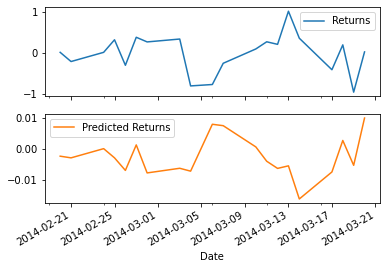

In [64]:
# Plot the first 20 predictions vs the true values
df[:20].plot(subplots=True)

In [67]:
df

,Returns,Predicted Returns
Date,,
2014-02-20,0.020465,-0.002385
2014-02-21,-0.204604,-0.002924
2014-02-24,0.020502,0.000041
2014-02-25,0.327970,-0.002924
2014-02-26,-0.296251,-0.006974
...,...,...
2019-10-09,-0.410601,-0.004906
2019-10-10,-0.369458,0.002754
2019-10-11,-0.564304,0.002212


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [85]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(df['Returns'],df['Predicted Returns'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"The mean squared error is: {mse}.")
print(f"The root-mean squared error is: {rmse}.")

The mean squared error is: 0.29782082335912147.
The root-mean squared error is: 0.5457296247768866.


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [104]:
# Construct a dataframe using just the "y" training data:
in_sample = pd.DataFrame(y_train)

# Add a column of "in-sample" predictions to that dataframe:  
in_sample['In-Sample Predictions']= model.predict(X_train)


# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample['Returns'], in_sample['In-Sample Predictions'])
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)

print(f"The in-sample mse is: {in_sample_mse}")
print(f"The in-sample rsme is: {in_sample_rmse}")

The in-sample mse is: 0.29782082335912147
The in-sample rsme is: 0.5457296247768866


# Conclusions

YOUR CONCLUSIONS HERE!